In [39]:
import torch
import torch.nn as nn


In [40]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
df = pd.read_parquet('set0.parquet', dtype_backend = 'pyarrow')[['X_jets','y']]

In [41]:
df.columns

Index(['X_jets', 'y'], dtype='object')

In [42]:
# set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [43]:
df = df.iloc[:2000]

In [44]:
# Convert to tensors
X = torch.tensor(df['X_jets'].values, dtype = torch.float32)
y = torch.tensor(df['y'].values, dtype = torch.float32)

In [45]:
df = None

In [46]:
print(X.shape, y.shape)

torch.Size([2000, 3, 125, 125]) torch.Size([2000])


In [47]:
# Separating into training and test data
testLen = 0.2*X.shape[0]
X_train = X[:int(X.shape[0]-testLen)]
y_train = y[:int(X.shape[0]-testLen)]

X_test = X[int(X.shape[0]-testLen):]
y_test = y[int(X.shape[0]-testLen):]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

X = None
y = None

torch.Size([1600, 3, 125, 125]) torch.Size([1600])
torch.Size([400, 3, 125, 125]) torch.Size([400])


In [48]:
# Separating into training and validation data
valLen = 0.2*X_train.shape[0]

X_valid = X_train[:int(valLen)]
y_valid = y_train[:int(valLen)]

X_train = X_train[int(valLen):]
y_train = y_train[int(valLen):]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

torch.Size([1280, 3, 125, 125]) torch.Size([1280])
torch.Size([320, 3, 125, 125]) torch.Size([320])


In [49]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

torch.Size([1280, 3, 125, 125]) torch.Size([320, 3, 125, 125]) torch.Size([400, 3, 125, 125])
torch.Size([1280]) torch.Size([320]) torch.Size([400])


In [50]:
X_train = X_train.permute(0,3,2,1)
X_test = X_test.permute(0,3,2,1)
X_valid = X_valid.permute(0,3,2,1)

In [51]:
print(X_train.shape, X_valid.shape, X_test.shape)   

torch.Size([1280, 125, 125, 3]) torch.Size([320, 125, 125, 3]) torch.Size([400, 125, 125, 3])


In [52]:
# Normalizing the Train and Validation data
# X_train_mean = X_train.mean()
# X_train_std = X_train.std()

# X_train = (X_train - X_train_mean) / (X_train_std + 1e-6)
# X_valid = (X_valid - X_train_mean) / (X_train_std + 1e-6)

In [53]:
# Create DataLoaders
from torch.utils.data import DataLoader, TensorDataset
trainSet = TensorDataset(X_train, y_train)
validSet = TensorDataset(X_valid, y_valid)
testSet = TensorDataset(X_test, y_test)

X_train = None
y_train = None
X_valid = None

batchSize = 32
trainLoader = DataLoader(trainSet, batch_size = batchSize, shuffle = True)
validLoader = DataLoader(validSet, batch_size = batchSize, shuffle = True)
testLoader = DataLoader(testSet, batch_size = batchSize, shuffle = True)

trainSet = None
validSet = None
testSet = None

In [54]:
for i in trainLoader:
    print(i[0].shape, i[1].shape)
    break

torch.Size([32, 125, 125, 3]) torch.Size([32])


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CustomCNN(nn.Module):
    def __init__(self, base_hidden_units, weight_decay):
        super(CustomCNN, self).__init__()
        self.base_hidden_units = base_hidden_units
        self.weight_decay = weight_decay

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=base_hidden_units*2, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(base_hidden_units)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=base_hidden_units*2, out_channels=base_hidden_units, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(base_hidden_units)

        # Pool + Dropout
        self.maxpool1 = nn.MaxPool2d(kernel_size=3)
        self.dropout1 = nn.Dropout(0.2)

        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=base_hidden_units, out_channels=base_hidden_units*2, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(base_hidden_units*2)

        # Convolutional Layer 4
        self.conv4 = nn.Conv2d(in_channels=base_hidden_units*2, out_channels=base_hidden_units*2, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(base_hidden_units*2)

        # Pool + Dropout
        self.maxpool2 = nn.MaxPool2d(kernel_size=3)
        self.dropout2 = nn.Dropout(0.2)

        # Convolutional Layer 5
        self.conv5 = nn.Conv2d(in_channels=base_hidden_units*2, out_channels=base_hidden_units*4, kernel_size=3, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(base_hidden_units*4)

        # Convolutional Layer 6
        self.conv6 = nn.Conv2d(in_channels=base_hidden_units*4, out_channels=base_hidden_units*4, kernel_size=3, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(base_hidden_units*4)

        # Pool + Dropout
        self.maxpool3 = nn.MaxPool2d(kernel_size=3)
        self.dropout3 = nn.Dropout(0.2)

        # Fully Connected Layer 1
        self.fc = nn.Linear(base_hidden_units*4 * 4 * 4, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        # x = self.batchnorm1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)

        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.relu(x)
        # x = self.batchnorm3(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.batchnorm4(x)

        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.relu(x)
        # x = self.batchnorm5(x)

        x = self.conv6(x)
        x = self.relu(x)
        x = self.batchnorm6(x)

        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = x.view(-1, self.base_hidden_units*4 * 4 * 4)  # Flatten
        x = self.fc(x)

        return x

# Initialize the model
base_hidden_units = 32
weight_decay = 0.01
model = CustomCNN(base_hidden_units, weight_decay).to(device)

# Print model summary
summary(model, input_size=(3, 125, 125))  # Assuming input image size is 32x32x3


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           1,792
              ReLU-2         [-1, 64, 125, 125]               0
            Conv2d-3         [-1, 32, 125, 125]          18,464
              ReLU-4         [-1, 32, 125, 125]               0
       BatchNorm2d-5         [-1, 32, 125, 125]              64
         MaxPool2d-6           [-1, 32, 41, 41]               0
           Dropout-7           [-1, 32, 41, 41]               0
            Conv2d-8           [-1, 64, 41, 41]          18,496
              ReLU-9           [-1, 64, 41, 41]               0
           Conv2d-10           [-1, 64, 41, 41]          36,928
             ReLU-11           [-1, 64, 41, 41]               0
      BatchNorm2d-12           [-1, 64, 41, 41]             128
        MaxPool2d-13           [-1, 64, 13, 13]               0
          Dropout-14           [-1, 64,

In [56]:
criterion = nn.CrossEntropyLoss()
#use sgd optimizer
optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

In [57]:
num_epochs = 50

In [58]:
# Training Loop
model.train()

CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv

In [59]:
for image,label in trainLoader:
    print(image.shape)
    break

torch.Size([32, 125, 125, 3])


In [60]:
trainLoss = []
trainAccuracy = []

validLoss = []
validAccuracy = []

In [61]:
import gc

def write_accuracies(message, file_path):
    with open(file_path, 'a') as file:
        file.write(message)
        file.write('\n')

for epoch in range(num_epochs):
    batch = 1
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    # Training loop
    for i, (images, labels) in enumerate(trainLoader):
        # permute the image dimensions
        number = len(images)
        arr = [torch.tensor(i).permute(2, 0, 1) for i in images]
        images = torch.stack(arr)

        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, torch.tensor(labels, dtype=torch.long))
        
        # Backward and optimize
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Memory cleanup
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch {batch}/{len(trainLoader)}, Train Loss: {loss.item():.4f}")
        batch += 1

    # Calculate training accuracy and loss
    training_accuracy = 100 * correct_train / total_train
    training_loss = total_train_loss / len(trainLoader)
    
    trainLoss.append(training_loss)
    trainAccuracy.append(training_accuracy)

    # Validation loop
    with torch.no_grad():
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        for images, labels in validLoader:
            # permute the image dimensions
            number = len(images)
            arr = [torch.tensor(i).permute(2, 0, 1) for i in images]
            images = torch.stack(arr)

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, torch.tensor(labels, dtype=torch.long))

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy and loss
    validation_accuracy = 100 * correct_val / total_val
    validation_loss = total_val_loss / len(validLoader)
    
    validLoss.append(validation_loss)
    validAccuracy.append(validation_accuracy)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {training_loss:.4f}, Train Accuracy: {training_accuracy:.2f}%, \
    Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    # Write accuracies to file
    write_accuracies(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {training_loss:.4f}, Train Accuracy: {training_accuracy:.2f}%, \
    Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%', "accuracies.txt")


Epoch [1/50], Batch 1/40, Train Loss: 0.9266


/tmp/ipykernel_296530/2324795026.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = [torch.tensor(i).permute(2, 0, 1) for i in images]
/tmp/ipykernel_296530/2324795026.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(labels, dtype=torch.long))


Epoch [1/50], Batch 2/40, Train Loss: 6.0752
Epoch [1/50], Batch 3/40, Train Loss: 33.6357
Epoch [1/50], Batch 4/40, Train Loss: 1.1859
Epoch [1/50], Batch 5/40, Train Loss: 33.6206
Epoch [1/50], Batch 6/40, Train Loss: 27.5071


Epoch [1/50], Batch 7/40, Train Loss: 0.8813
Epoch [1/50], Batch 8/40, Train Loss: 23.3524
Epoch [1/50], Batch 9/40, Train Loss: 19.9739
Epoch [1/50], Batch 10/40, Train Loss: 2.2292
Epoch [1/50], Batch 11/40, Train Loss: 35.0009
Epoch [1/50], Batch 12/40, Train Loss: 17.0667
Epoch [1/50], Batch 13/40, Train Loss: 9.0368
Epoch [1/50], Batch 14/40, Train Loss: 2.2712
Epoch [1/50], Batch 15/40, Train Loss: 6.5894
Epoch [1/50], Batch 16/40, Train Loss: 3.8786
Epoch [1/50], Batch 17/40, Train Loss: 0.7318
Epoch [1/50], Batch 18/40, Train Loss: 20.2830
Epoch [1/50], Batch 19/40, Train Loss: 5.9753
Epoch [1/50], Batch 20/40, Train Loss: 2.4636
Epoch [1/50], Batch 21/40, Train Loss: 7.4002
Epoch [1/50], Batch 22/40, Train Loss: 4.8083
Epoch [1/50], Batch 23/40, Train Loss: 2.0990
Epoch [1/50], Batch 24/40, Train Loss: 4.0855
Epoch [1/50], Batch 25/40, Train Loss: 9.8109
Epoch [1/50], Batch 26/40, Train Loss: 2.5800
Epoch [1/50], Batch 27/40, Train Loss: 5.9349
Epoch [1/50], Batch 28/40, Train

/tmp/ipykernel_296530/2324795026.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = [torch.tensor(i).permute(2, 0, 1) for i in images]
/tmp/ipykernel_296530/2324795026.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(labels, dtype=torch.long))


Epoch [2/50], Batch 1/40, Train Loss: 3.1300
Epoch [2/50], Batch 2/40, Train Loss: 2.1109
Epoch [2/50], Batch 3/40, Train Loss: 1.6220
Epoch [2/50], Batch 4/40, Train Loss: 4.5157
Epoch [2/50], Batch 5/40, Train Loss: 0.7255
Epoch [2/50], Batch 6/40, Train Loss: 6.6774
Epoch [2/50], Batch 7/40, Train Loss: 0.8841
Epoch [2/50], Batch 8/40, Train Loss: 0.6606
Epoch [2/50], Batch 9/40, Train Loss: 1.0299
Epoch [2/50], Batch 10/40, Train Loss: 1.6613
Epoch [2/50], Batch 11/40, Train Loss: 3.9407
Epoch [2/50], Batch 12/40, Train Loss: 3.8082
Epoch [2/50], Batch 13/40, Train Loss: 2.4034
Epoch [2/50], Batch 14/40, Train Loss: 1.3450
Epoch [2/50], Batch 15/40, Train Loss: 5.1409
Epoch [2/50], Batch 16/40, Train Loss: 6.1373
Epoch [2/50], Batch 17/40, Train Loss: 1.5451
Epoch [2/50], Batch 18/40, Train Loss: 1.1751
Epoch [2/50], Batch 19/40, Train Loss: 2.6455
Epoch [2/50], Batch 20/40, Train Loss: 3.1156
Epoch [2/50], Batch 21/40, Train Loss: 1.8739
Epoch [2/50], Batch 22/40, Train Loss: 1.94

In [62]:
#import F

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testLoader:
        
        # permute the image dimensions

        number = len(images)
        arr = [torch.tensor(i).permute(2,0,1) for i in images]

        images = torch.stack(arr)
    
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    write_accuracies(f'Test Accuracy of the model on the test images: {100 * correct / total} %', "accuracies.txt")



/tmp/ipykernel_296530/285983815.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = [torch.tensor(i).permute(2,0,1) for i in images]


Test Accuracy of the model on the test images: 64.0 %


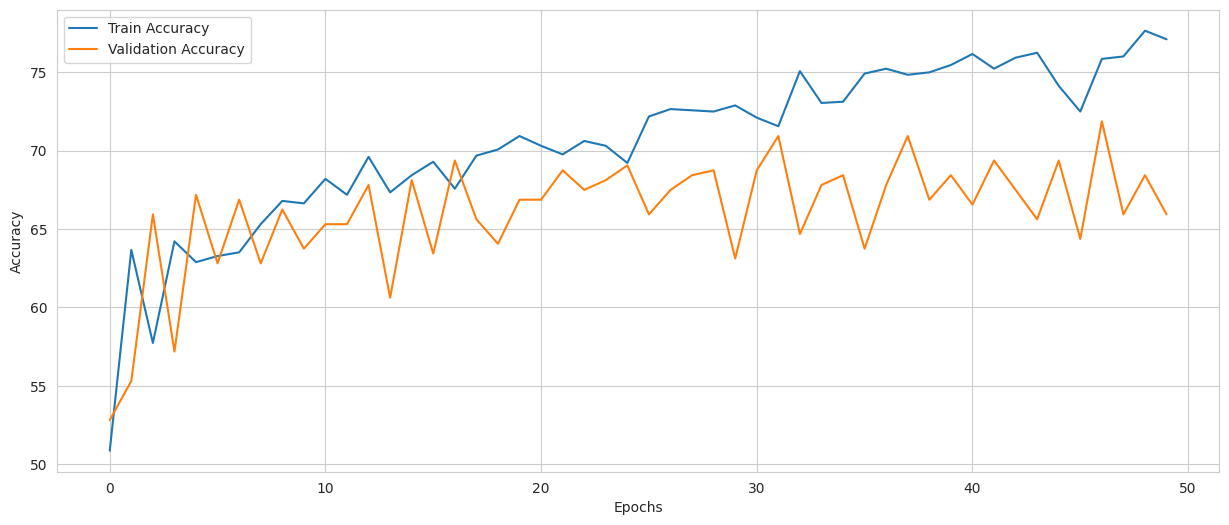

In [63]:
#Plotting the accuracies
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
x = [i for i in range(num_epochs)]
plt.figure(figsize=(15, 6))

plt.plot(x, trainAccuracy, label = 'Train Accuracy')
plt.plot(x, validAccuracy, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

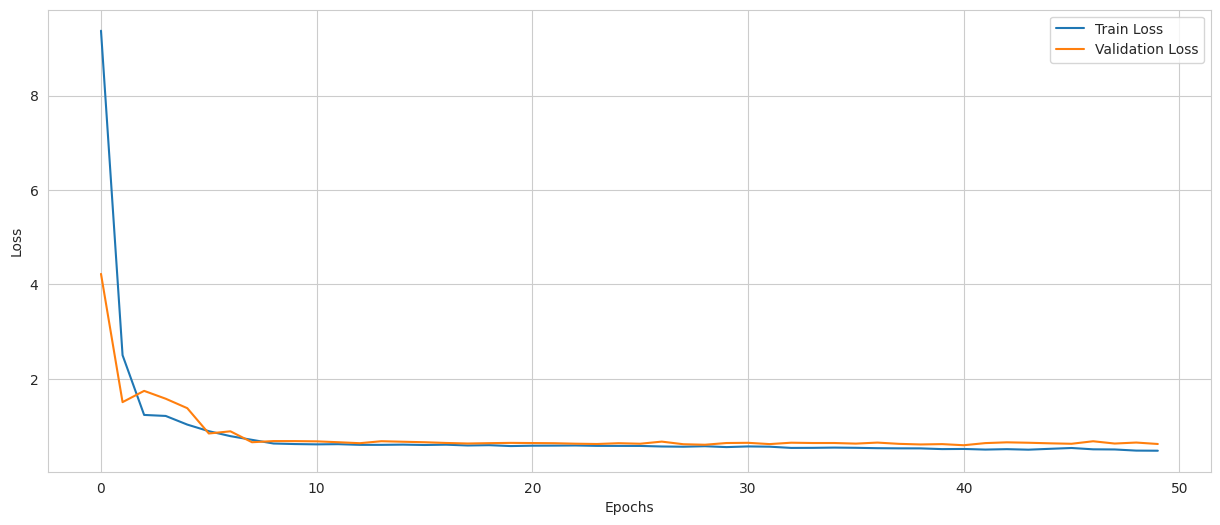

In [64]:
# Plotting the losses
import seaborn as sns
plt.figure(figsize=(15, 6))
sns.set_style('whitegrid')
plt.plot(x, trainLoss, label = 'Train Loss')
plt.plot(x, validLoss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()